In [1]:
import torch
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

In [327]:
# Set a seed for reproducibility
torch.manual_seed(0)

# Number of samples
n_samples = 100
ns = torch.linspace(0, 4 * 3.14, n_samples)
# Generate three source signals
s1 = torch.sin(2 * ns)  # Signal 1 : sinusoidal signal
s2 = torch.sign(torch.sin(3 * ns))  # Signal 2 : square signal
s3 = torch.rand(n_samples)  # Signal 3 : uniformly distributed random signal

# Stack the sources vertically
S = torch.stack((s1, s2, s3))

# Standardize the sources
S = (S - torch.mean(S, dim=1, keepdim=True)) / torch.std(S, dim=1, keepdim=True)

# Create a mixing matrix
A = torch.tensor([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])

# Mix the sources
X = torch.mm(A, S)

print("Shape of the generated data: ", X.shape)

Shape of the generated data:  torch.Size([3, 100])


In [328]:
ns = ns.numpy()

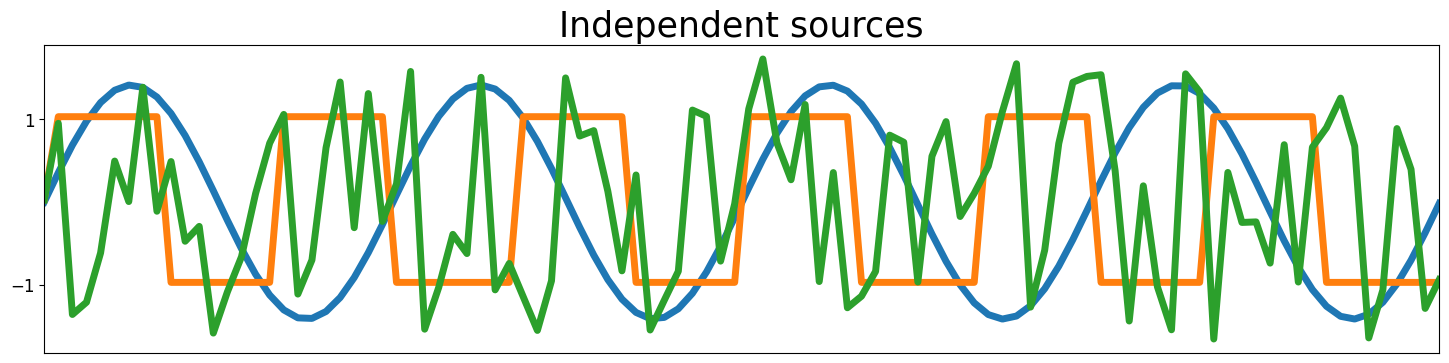

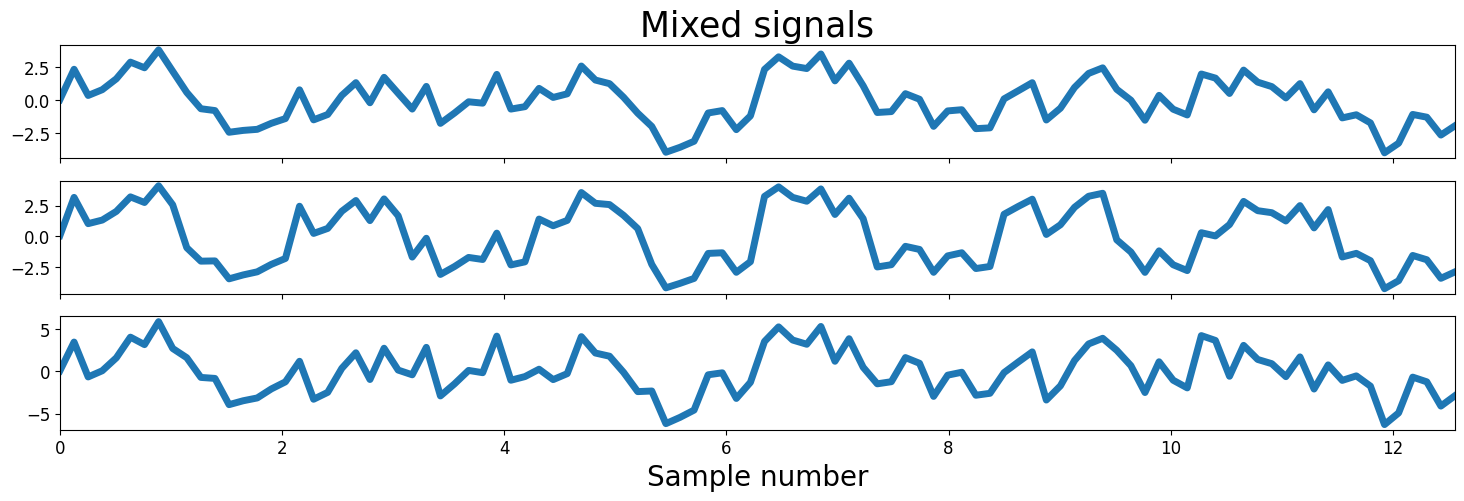

In [336]:
# Plot sources & signals

fig, ax = plt.subplots(1, 1, figsize=[18, 4])
ax.plot(ns, S.clone().detach().numpy().T, lw=5)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(ns[0], ns[n_samples-1])
ax.tick_params(labelsize=12)
ax.set_title('Independent sources', fontsize=25)

# plt.savefig('source_signals.png')

fig, ax = plt.subplots(3, 1, figsize=[18, 5], sharex=True)
ax[0].plot(ns, X[0], lw=5)
ax[0].set_title('Mixed signals', fontsize=25)
ax[0].tick_params(labelsize=12)

ax[1].plot(ns, X[1], lw=5)
ax[1].tick_params(labelsize=12)
ax[1].set_xlim(ns[0], ns[-1])

ax[2].plot(ns, X[2], lw=5)
ax[2].tick_params(labelsize=12)
ax[2].set_xlim(ns[0], ns[-1])
ax[2].set_xlabel('Sample number', fontsize=20)
ax[2].set_xlim(ns[0], ns[n_samples-1])

plt.show()
# plt.savefig('mixed_signals.png')

In [306]:
class FastICA():
    def __init__(
        self, 
        n_components = 5,
        max_iter = 500,
        alpha = 0.01,
        tol=1e-4,
        non_linearity = 'tanh'
        ):
        self.n_components = n_components
        self.non_linearity = non_linearity
        self.tol = tol
        
    @staticmethod
    def _logcosh(self, x):
        """Logcosh function."""
        return torch.log(torch.cosh(x))

    @staticmethod
    def _tanh(self, x):
        """Hyperbolic tangent function."""
        return torch.tanh(x)
        
    @staticmethod
    def _symmetric_decorrelation(W):
        K = torch.mm(W, W.t())
        s, u = torch.linalg.eigh(K)
        return torch.mm(torch.mm(torch.mm(u, torch.diag(1.0 / torch.sqrt(s))), u.t()),  W)

    
    def fit_transform(self, X):
        n, m = X.shape
        if self.non_linearity == 'logcosh':
            g = FastICA._logcosh
            g_prime = lambda x: torch.tanh(x)
        elif self.non_linearity == 'tanh':
            g = FastICA._tanh
            g_prime = lambda x: 1.0 - torch.tanh(x) ** 2
        else:
            raise ValueError("Invalid nonlinearity. Choose 'logcosh' or 'tanh'.")
        # Whitening
        X -= X.mean(dim=1, keepdim = True)
        U, D, _ = torch.svd(torch.matmul(X, X.T) / n_samples)
        whiteM = torch.matmul(torch.diag(1.0 / D), U.T)
        whiteM = torch.matmul(U,whiteM)
        X_white = torch.matmul(whiteM, X)
        W = torch.randn(X.shape[0],X.shape[0], dtype=x.dtype, device=x.device)

        for _ in range(max_iter):
            W_prev = W.clone()
            # Estimate sources
            Y = torch.matmul(W.T, X_white)
            Y = g(self,Y)
            # Update weights
            W_grad = torch.matmul(X_white, Y.T) / n_samples # X_white 3x10, Y 10x3
            W_grad -= torch.mean(g_prime(Y), dim=1, keepdim=True)*W_grad
            W = (1 - alpha) * W + alpha * W_grad
        
            # Symmetric orthogonalization
            W = FastICA._symmetric_decorrelation(W)
        
            # # Check convergence
            if torch.norm(W - W_prev) < self.tol:
                break
        
        return W, S
              

In [290]:
ica_estimator = FastICA(n_components = 3)

In [291]:
W, S_ = ica_estimator.fit_transform(X)

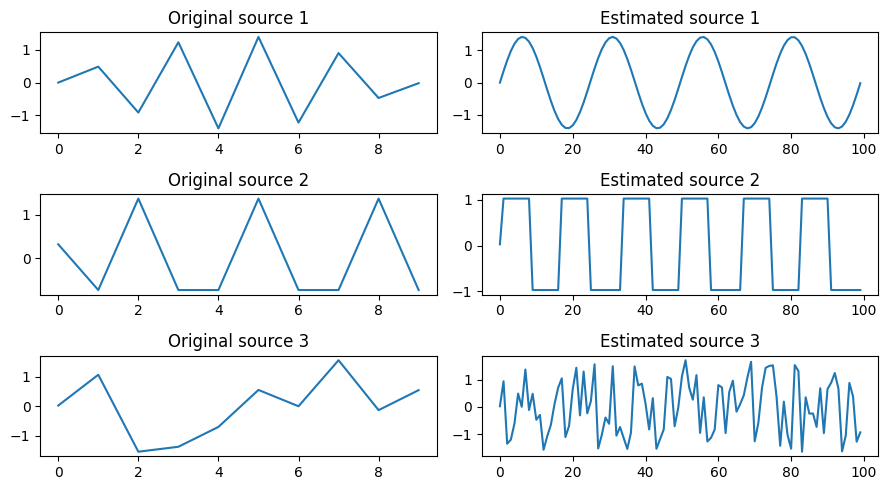

In [337]:
# Assume S_ is the estimated sources
# Plot original sources
plt.figure(figsize=(9, 5))
for i, x in enumerate(S_):
    plt.subplot(3, 2, 2*i+1)
    plt.plot(x)
    plt.title(f'Original source {i+1}')

# Plot estimated sources
for i, x in enumerate(S):
    plt.subplot(3, 2, 2*i+2)
    plt.plot(x.detach().numpy())
    plt.title(f'Estimated source {i+1}')

plt.tight_layout()

plt.savefig('estimated_orginal_source.png')
# plt.show()

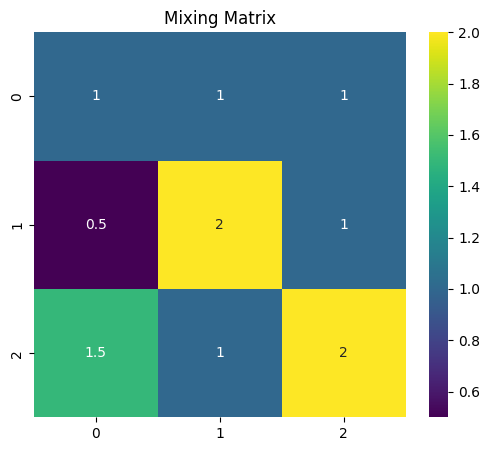

In [298]:
# Assume A is your mixing matrix

# Convert the tensor to numpy for visualization
A_np = A.numpy()

# Create a heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(A_np, annot=True, cmap='viridis')
plt.title('Mixing Matrix')
plt.show()